# Name: Nhat Minh Dang
## Customer Churn Project

### A) Introduction:

In this project, I will utilize Microsoft Fabric to train data using Machine Learning Models and evaluate the result. The Data contains customer information and their membership status. The data will be loaded into Microsoft Lakehouse before processing it using Python Notebook.

### B) Libraries and Data Preparation:

#### 1. Install Libraries: 
Below are the libraries that I will use for this project:

- imblearn: Provides tools to handle class imbalance in datasets, crucial for churn prediction.
- time: Enables time tracking for performance benchmarking and execution profiling.
- seaborn: Provides high-level statistical data visualization, ideal for exploring churn patterns and correlations.
- pandas: Core library for data manipulation and analysis, essential for handling customer data tables.
- matplotlib.pyplot: Offers flexible plotting capabilities for visualizing trends, distributions, and model outputs.
- matplotlib.ticker: Allows fine control over axis tick formatting, useful for dashboard-ready plots.
- matplotlib: Customizes global plot aesthetics like fonts and layout to enhance visual clarity.
- numpy: Supports numerical operations and array manipulation, foundational for feature engineering and model input.
- itertools: Provides efficient tools for creating combinations and permutations, useful in hyperparameter tuning or feature interaction analysis.
- Counter: Quickly counts occurrences of elements, handy for class distribution checks in churn datasets.
- SMOTE: Applies Synthetic Minority Over-sampling Technique to balance churn vs. non-churn classes by generating synthetic samples.
- Train test split: Splits dataset into training and testing subsets to evaluate model performance on unseen data.
- LGBM Classifier: Loads the LightGBM classifier, a fast and efficient gradient boosting model ideal for handling large-scale, imbalanced churn datasets.
- Random Forest Classifier: Imports a robust ensemble learning model that builds multiple decision trees and aggregates their predictions for better accuracy and generalization.
- Accuracy score, f1 score, confusion matrix and recal score: These are the evaluation metrics for machine learning prediction result.
- Classification Report: Generates a full summary of evaluation result.


In [1]:
%pip install imblearn

import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 8, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 61.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Not uninstalling threadpoolctl at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-93daa38d-54f6-4e70-b586-df328b253183
    Can't uninstall 'threadpoolctl'. No files were found to uninstall.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Not uninstalling scikit-learn at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-93daa38d-54f6-4e70-b586-df328b253183
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

#### 2) Load Data:
Before creating this notebook, I have already created a Lakehouse to import the churn.csv. A Data Lakehouse is a modern data architecture that combines the scalability and flexibility of data lakes with the structured data management and performance capabilities of data warehouses. It enables organizations to store vast amounts of raw and processed data in a unified platform, supporting both analytical and machine learning workloads without the need for complex data movement or duplication. By integrating ACID transactions, schema enforcement, and metadata management into the lake environment, lakehouses allow for reliable, high-performance querying while maintaining the cost-efficiency and openness of cloud-based storage. This hybrid approach empowers teams to streamline data pipelines, reduce latency, and accelerate insights across diverse business domains.

In [2]:
DATA_ROOT = "lakehouse/default"
DATA_FOLDER = "Files"
DATA_FILE = "churn.csv"

ts = time.time()

df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv("Files/churn.csv")
    .cache()
)


display(df)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 10, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ea2f7dd2-166f-4293-8af6-fd050791b552)

As can be seen in the dataset, these are multiple columns that contain information about customer. While some columns such as Customer ID, Surname, Gender, Age and Geography contribute almost no weight into the training and predicting process, other elements such as Number of Products, Has Credit Card, Credit Score, etc are important statistics that provides meaningful insights for the learning process.

In [3]:
table_name = "df_input"
df.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
df = df.toPandas()

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 11, Finished, Available, Finished)

This part saves a a Spark DataFrame (df) as a Delta table named "df_input". The process will replace any existing table with same name using Delta Lake Format. 

Delta Lake is an open-source storage format that brings reliability, performance, and scalability to data lakes by adding ACID transaction support, schema enforcement and time travel capabilities. Built on top of Apache Spark, it enables seamless reads and writes of large-scale data while maintaining consistency and data integrity—critical for analytics and machine learning workflows. Delta Lake also supports efficient data updates and deletes, making it ideal for handling slowly changing dimensions and GDPR-compliant data pipelines. Its ability to unify batch and streaming data in a single architecture empowers organizations to simplify their data infrastructure while accelerating insight delivery.

In [4]:
row_count = df.count()
print(f"Number of rows: {row_count}")

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 12, Finished, Available, Finished)

Number of rows: RowNumber          10000
CustomerId         10000
Surname            10000
CreditScore        10000
Geography          10000
Gender             10000
Age                10000
Tenure             10000
Balance            10000
NumOfProducts      10000
HasCrCard          10000
IsActiveMember     10000
EstimatedSalary    10000
Exited             10000
dtype: int64


As can be seen from the result, the number of Rows are equal, meaning that there is no null elements. Therefore, the data can be proceed to the next step.

#### 3) Exploratory Data Analysis:

Before digesting deeper into the dataset, below is the summary of information collected from data:

In [5]:
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})

# Summary
display(df, summary=True)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 13cf2626-a3ec-4695-88e7-7d239e370597)

In [6]:
#Check columns list and missing values.
df.isnull().sum()

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 14, Finished, Available, Finished)

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### 4) Data Cleaning:

In the code below, I have deleted any columns with duplicated row number and customer id, followed by any columns that does not contribute to the training process.

In [7]:
def clean_data(df):
    df = df.dropna()
    df = df.drop_duplicates(subset=['RowNumber', 'CustomerId'])
    df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
    return df

df_clean = clean_data(df.copy())
display(df_clean)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 15, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, e8e9b3cb-48ee-4fb5-b5d9-9fc716712cbe)

In [8]:
row_count = df_clean.count()
row_count

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 16, Finished, Available, Finished)

CreditScore        10000
Geography          10000
Gender             10000
Age                10000
Tenure             10000
Balance            10000
NumOfProducts      10000
HasCrCard          10000
IsActiveMember     10000
EstimatedSalary    10000
Exited             10000
dtype: int64

#### 5) Determine Attributes:
Below are the attributes that I will use as target:

In [9]:
#Determine the dependent attribute (target attribute).
dependent_variable_name = "Exited"
print("Target variable:")
print(dependent_variable_name)

#Categorical attributes.
categorical_variables = [
    col for col in df_clean.columns if df_clean[col].dtype == "object"
    or df_clean[col].nunique() <=5
    and col not in "Exited"
]
print("\nCategorical Variables:")
print(categorical_variables)

#Numerical attributes.
numeric_variables = [
    col for col in df_clean.columns if df_clean[col].dtype != "object"
    and df_clean[col].nunique() > 5
]
print("\nNumerical Variables:")
print(numeric_variables)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 17, Finished, Available, Finished)

Target variable:
Exited

Categorical Variables:
['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

Numerical Variables:
['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


#### 6) Central Tendency and Distribution of Numericcal Data:

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 18, Finished, Available, Finished)

/tmp/ipykernel_9377/2417626394.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


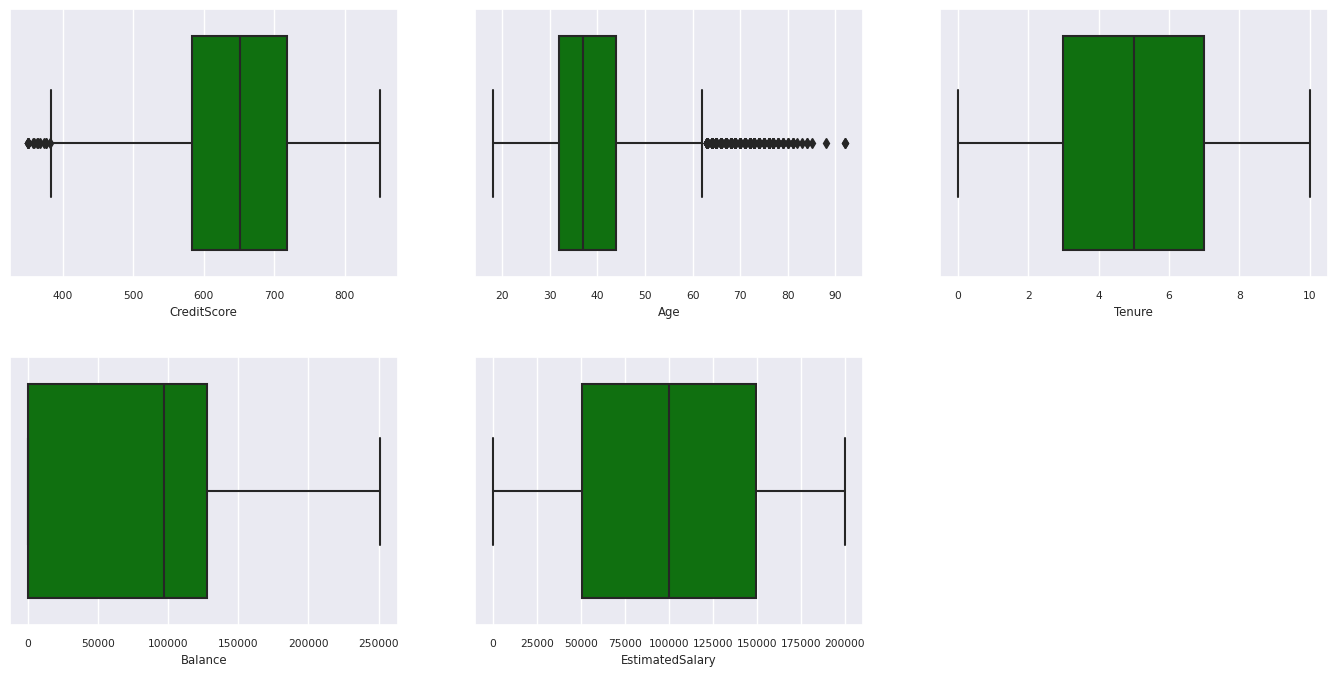

In [10]:
#Box plot display.
df_num_cols = df_clean[numeric_variables]
sns.set(font_scale = 0.7) 
fig, axes = plt.subplots(nrows = 2, ncols = 3, gridspec_kw =  dict(hspace=0.3), figsize = (17,8))
fig.tight_layout()
for ax,col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x = df_num_cols[col], color='green', ax = ax)

fig.delaxes(axes[1,2])


The box plots provide a visual summary of five key numerical variables — Credit Score, Age, Tenure, Balance and EstimatedSalary—highlighting their distribution, central tendency and presence of outliers. Credit Score appears relatively symmetric, with a tight interquartile range and a few low-end outliers, suggesting consistent scoring across most customers. Age shows a wider spread and a notable cluster of high-end outliers, indicating a subset of significantly older individuals that may warrant segmentation. Tenure is uniformly distributed with no visible outliers, implying stable customer retention durations. Balance spans a broad range but remains free of outliers, suggesting diverse financial holdings without extreme anomalies. Lastly, Estimated Salary also exhibits a wide distribution with no outliers, reflecting varied income levels across the customer base. This analysis is valuable for feature scaling, outlier treatment and understanding the underlying variability that may influence churn behavior.


StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 19, Finished, Available, Finished)

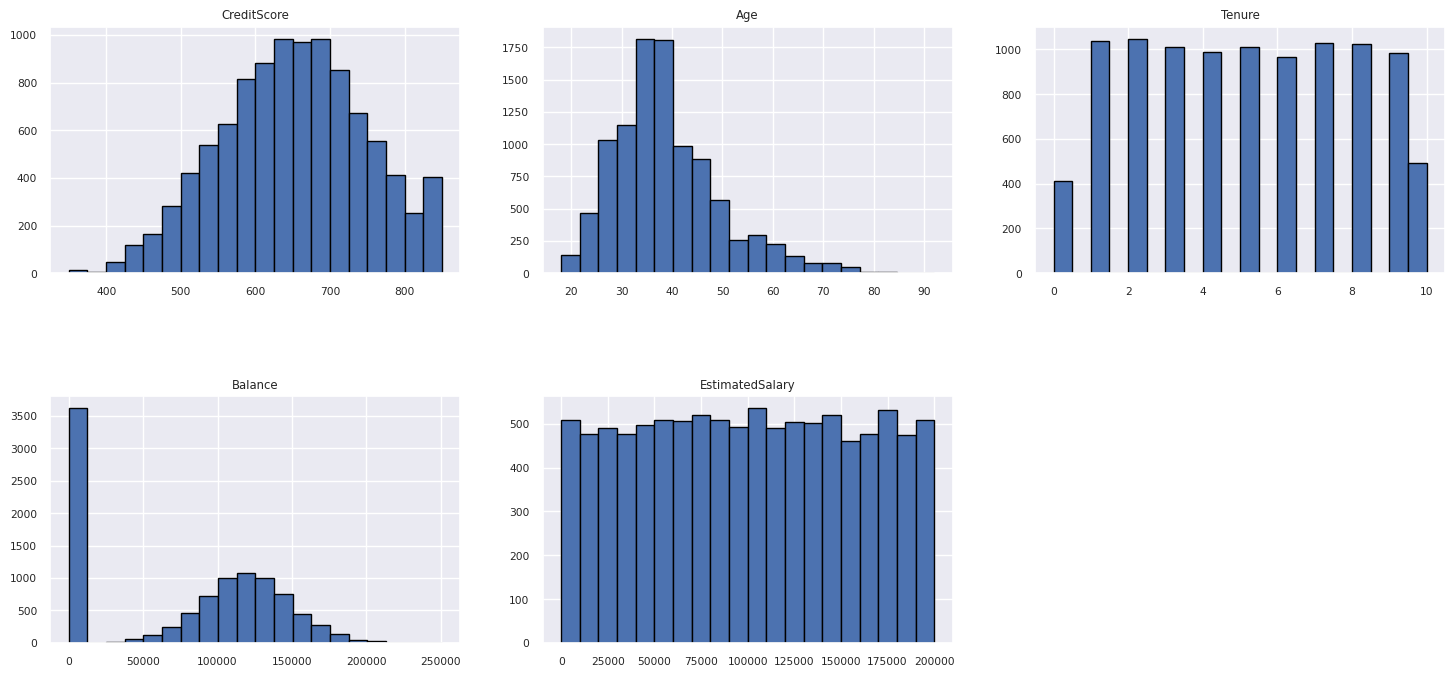

In [11]:
columns = df_num_cols.columns[: len(df_num_cols.columns)]
fig = plt.figure()
fig.set_size_inches(18, 8)
length = len(columns)
for i,j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    df_num_cols[i].hist(bins = 20, edgecolor = 'black')
    plt.title(i)

plt.show()

The histograms reveal distinct distribution patterns across five key customer variables, offering valuable insights for churn modeling and segmentation. CreditScore follows a roughly normal distribution centered around 650–700, indicating a consistent credit profile among most customers. Age displays a bimodal shape with peaks near 30 and 40, and a sharp decline after 60, suggesting two dominant age groups and fewer elderly customers. Tenure is evenly spread from 0 to 10 years, reflecting a balanced mix of new and long-term clients. Balance is heavily right-skewed, with many customers maintaining near-zero balances and a gradual tapering toward higher amounts—potentially signaling inactive or low-engagement accounts. Lastly, EstimatedSalary shows a uniform distribution across the income range, implying that salary alone may not be a strong churn predictor without further feature interaction. These patterns help guide feature engineering, normalization strategies and targeted retention efforts


There are six categories that I will use for the training process: 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure'. Below is my set up and result for data overview of categorical data.

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 20, Finished, Available, Finished)

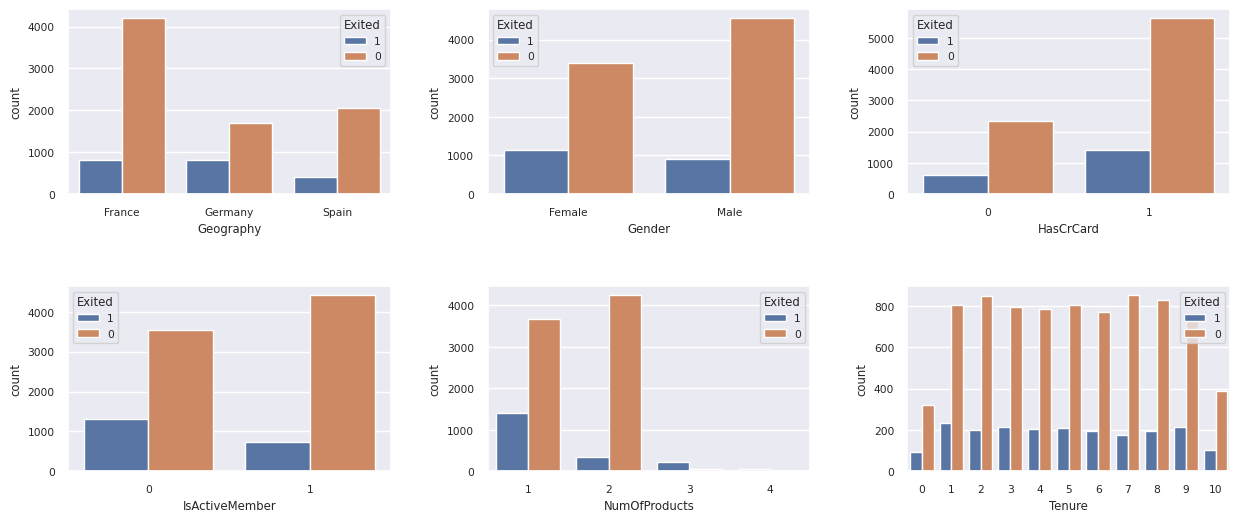

In [12]:
attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']

#Convert relevant columns and 'Exited' to string
df_clean[attr_list] = df_clean[attr_list].astype(str)
df_clean['Exited'] = df_clean['Exited'].astype(str)

#Plot
fig, axarr = plt.subplots(2, 3, figsize=(15, 6))
axarr = axarr.flatten()

for ind, item in enumerate(attr_list):
    # try to sort numerically, else lexicographically
    try:
        order = sorted(df_clean[item].unique(), key=lambda x: int(x))
    except ValueError:
        order = sorted(df_clean[item].unique())
    
    sns.countplot(
        x=item,
        hue='Exited',
        data=df_clean,
        ax=axarr[ind],
        order=order
    )

fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

Based on the visual output, these insights can be concluded:
- Geography:
France has the largest customer base but a lower churn rate. Germany shows a disproportionately high churn rate, suggesting geography may be a strong predictor.
- Gender:
While males dominate in count, females exhibit a higher churn proportion, indicating potential behavioral or service-related differences.
- HasCrCard:
Most customers have a credit card, and those without one tend to churn more frequently—possibly reflecting engagement or financial trust.
- IsActiveMember:
Inactive members (IsActiveMember = 0) show significantly higher churn, reinforcing the importance of engagement metrics.
- NumOfProducts:
Customers with only one product are more likely to churn, while those with multiple products (especially 3 or 4) show strong retention—highlighting cross-sell opportunities.
- Tenure:
Tenure appears evenly distributed, with no strong churn trend across years, suggesting it may be a weaker standalone predictor.


Finally, I will ensure the numeric columns are in correct format and perform one hot encoding for the categorical columns. The data will be saved as df_clean:

In [13]:
#Ensure numeric columns
df_clean['Tenure'] = pd.to_numeric(df_clean['Tenure'], errors='coerce')
df_clean['Age'] = pd.to_numeric(df_clean['Age'], errors='coerce')

df_clean["NewTenure"] = df_clean["Tenure"]/df_clean["Age"]
df_clean["NewCreditsScore"] = pd.qcut(df_clean['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 21, Finished, Available, Finished)

In [14]:
def clean_data(df_clean):
    #One-hot encode columns: 'Geography', 'Gender'.
    for column in ['Geography', 'Gender']:
        insert_loc = df_clean.columns.get_loc(column)
        df_clean = pd.concat([df_clean.iloc[:,:insert_loc], pd.get_dummies(df_clean.loc[:, [column]]), df_clean.iloc[:,insert_loc+1:]], axis=1)
    #Change column type to int64 for columns: 'Geography_France', 'Geography_Germany' and 3 other columns.
    df_clean = df_clean.astype({'Geography_France': 'int64', 'Geography_Germany': 'int64', 'Geography_Spain': 'int64', 'Gender_Female': 'int64', 'Gender_Male': 'int64'})
    return df_clean

df_clean_1 = clean_data(df_clean.copy())
display(df_clean_1)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 22, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ca470c08-064c-445e-8eda-0baa0eebffaf)

In [15]:
table_name = "df_clean"
# Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(df_clean) 
sparkDF.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 23, Finished, Available, Finished)

Spark dataframe saved to delta table: df_clean


#### 4. Model Training:

In this step, I will set up experiment environment for the training process.

In [16]:
SEED = 12345
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()
import mlflow

#Set up experiment name.
EXPERIMENT_NAME = "bank-churn-experiment" 

mlflow.set_experiment(EXPERIMENT_NAME) 
mlflow.autolog(exclusive=False)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 24, Finished, Available, Finished)

2025/10/01 02:51:46 INFO mlflow.tracking.fluent: Experiment with name 'bank-churn-experiment' does not exist. Creating a new experiment.
2025/10/01 02:51:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/10/01 02:51:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/10/01 02:51:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/01 02:51:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/10/01 02:51:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


The categorical columns that still have strings will be dropped, followed by splitting the dataset to training and test set with ratio 80:20.

In [17]:
#Training and test datasets
#Drop original categorical columns that still have strings
X = df_clean.drop(["Exited", "Geography", "Gender"], axis=1, errors="ignore")

#Convert booleans to int
X = X.astype(int, errors="ignore")

#Remaining non-boolean numeric columns to float
for col in X.columns:
    if X[col].dtype == "bool":
        X[col] = X[col].astype(int)
    elif X[col].dtype == "object":
        print("Non-numeric column found:", col)  # debug step

#Final check
print(X.dtypes.unique())

#Train-test split
y = df_clean["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)


StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 25, Finished, Available, Finished)

[dtype('int64')]


To ensure there will be no bias on any specific class or category, I use SMOTE to balance the training dataset. SMOTE (Synthetic Minority Over-sampling Technique) is a powerful technique used to address class imbalance in machine learning datasets. Instead of simply duplicating minority class samples, SMOTE creates synthetic examples by interpolating between existing minority instances. It selects a sample, finds its nearest neighbors, and generates new points along the line segments joining them. This helps the model learn a more general decision boundary and reduces the risk of overfitting to duplicated data. SMOTE is especially useful in classification problems where the minority class is underrepresented, such as fraud detection or medical diagnosis.

In [18]:
sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_train, y_train)
new_train = pd.concat([X_res, y_res], axis=1)
display(new_train)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 26, Finished, Available, Finished)

2025/10/01 02:51:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f311e010-b922-48d5-be49-12b56941ed63', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/10/01 02:51:56 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/10/01 02:51:56 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/10/01 02:51:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/01 02:52:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_dist

SynapseWidget(Synapse.DataFrame, 52f4e01c-54d3-48ea-bf5f-1b6b2acc69c7)

As a result, below is the new distribution of numericcal attributes:

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 27, Finished, Available, Finished)

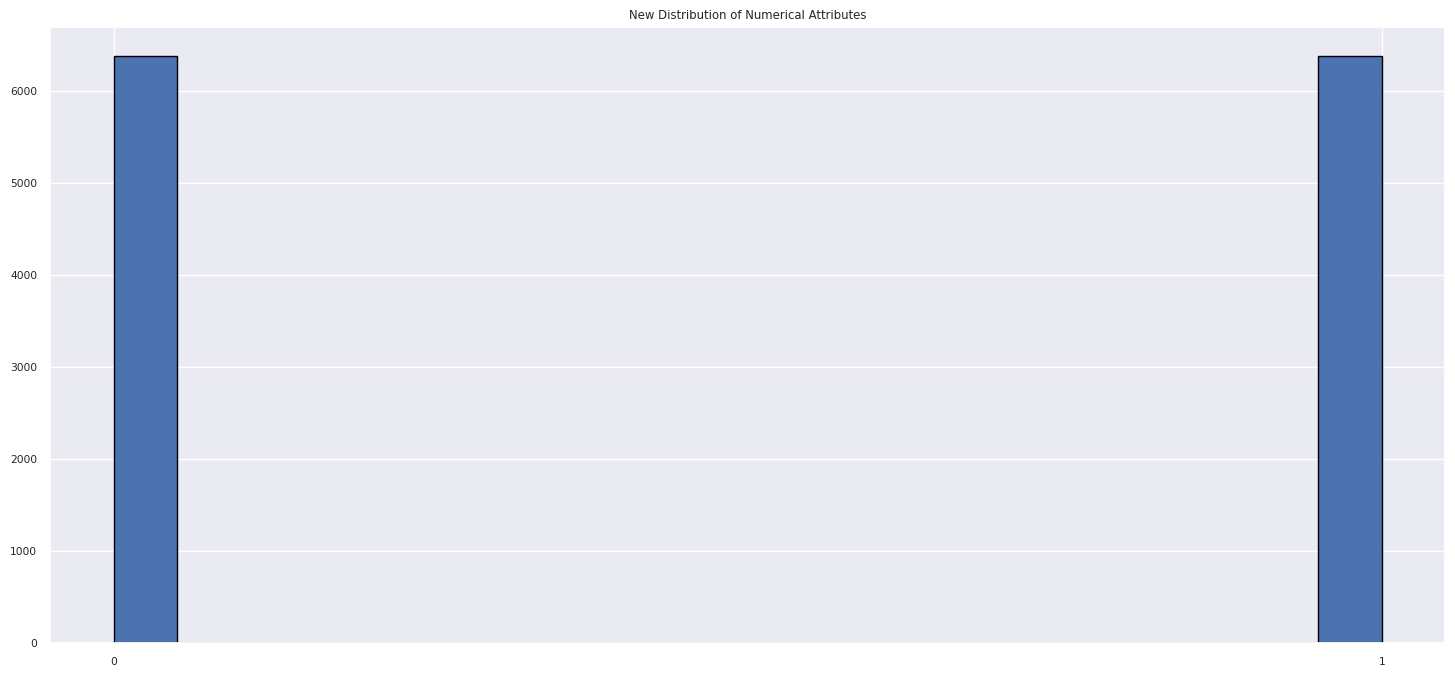

In [19]:
fig = plt.figure()
fig.set_size_inches(18, 8)
length = 1
new_train["Exited"].hist(bins = 20, edgecolor = 'black')
plt.title("New Distribution of Numerical Attributes")
plt.show()


For the training process, I will use Random Forest method with different configuration. Random Forest is an ensemble learning method that builds multiple decision trees and merges their predictions to improve accuracy and reduce overfitting. Each tree is trained on a random subset of the data and features, and the final prediction is made by aggregating the outputs—typically using majority voting for classification or averaging for regression. This randomness helps the model generalize better and handle noisy or imbalanced data. In this code, I will use max_depth to control tree complexity, max_features to limit the number of features considered at each split and min_samples_split to prevent overly specific branches. These hyperparameters help balance bias and variance, especially when working with synthetic data from SMOTE.

The first block trains a Random Forest model (rfc1_sm) with a shallow depth of 4 and only 4 features, aiming for simplicity and interpretability. It uses MLflow’s autologging to track parameters, metrics, and artifacts automatically. The model is trained on the SMOTE-balanced dataset (X_res, y_res) and evaluated on the original test set (X_test, y_test). Key metrics like classification report, confusion matrix, and ROC AUC score are computed to assess performance. 

The second block follows the same structure but uses a deeper forest (max_depth=8) and more features (max_features=6), allowing for more complex decision boundaries. This setup may capture more nuanced patterns in the data, potentially improving performance at the cost of interpretability. Both models are registered with MLflow for reproducibility and future deployment.


In [20]:
#Random Forest with max depth 4, with 4 features.
mlflow.sklearn.autolog(registered_model_name='rfc1_sm')  #Register the trained model with autologging
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) #Pass hyperparameters
with mlflow.start_run(run_name="rfc1_sm") as run:
    rfc1_sm_run_id = run.info.run_id #Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc1_sm_run_id, run.info.status))
    rfc1_sm.fit(X_res, y_res.ravel()) #balanced training data
    rfc1_sm.score(X_test, y_test)
    y_pred = rfc1_sm.predict(X_test)
    cr_rfc1_sm = classification_report(y_test, y_pred)
    cm_rfc1_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc1_sm = roc_auc_score(y_res, rfc1_sm.predict_proba(X_res)[:, 1])

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 28, Finished, Available, Finished)

2025/10/01 02:52:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/10/01 02:52:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missin

run_id: a1f82776-71e8-4207-8723-583b3a3afb83; status: RUNNING


In [21]:
#Random Forest with max depth 8, with 6 features.
mlflow.sklearn.autolog(registered_model_name='rfc2_sm')  #Register the trained model with autologging
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc2_sm") as run:
    rfc2_sm_run_id = run.info.run_id #Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc2_sm_run_id, run.info.status))
    rfc2_sm.fit(X_res, y_res.ravel()) #balanced training data
    rfc2_sm.score(X_test, y_test)
    y_pred = rfc2_sm.predict(X_test)
    cr_rfc2_sm = classification_report(y_test, y_pred)
    cm_rfc2_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc2_sm = roc_auc_score(y_res, rfc2_sm.predict_proba(X_res)[:, 1])

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 29, Finished, Available, Finished)

run_id: 6be82caf-42f3-44b4-be3e-f9996ad5a0c5; status: RUNNING


2025/10/01 02:52:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025-10-01:02:52:35,556 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"b

After training with Random Forest, I will train a LightGBM model (lgbm_sm_model) using SMOTE-balanced data and tracks the entire process with MLflow’s autologging for reproducibility and model management. The classifier is configured with a moderate learning rate, a controlled depth of 10, and 100 boosting iterations, aiming to balance performance and generalization. The training is conducted within an MLflow run named "lgbm_sm", capturing the run_id for future reference. After fitting the model on the resampled dataset (X_res, y_res), predictions are made on the original test set (X_test) to evaluate generalization. Key performance metrics—including accuracy, classification report, confusion matrix, and ROC AUC score on the training data—are computed to assess both predictive power and class separation. The model is also registered under the name 'lgbm_sm' for streamlined deployment and version control.

In [22]:
#lgbm_model
mlflow.lightgbm.autolog(registered_model_name='lgbm_sm')  #Register the trained model with autologging.
lgbm_sm_model = LGBMClassifier(learning_rate = 0.07, 
                        max_delta_step = 2, 
                        n_estimators = 100,
                        max_depth = 10, 
                        eval_metric = "logloss", 
                        objective='binary', 
                        random_state=42)

with mlflow.start_run(run_name="lgbm_sm") as run:
    lgbm1_sm_run_id = run.info.run_id #Capture run_id for model prediction later.
    lgbm_sm_model.fit(X_res, y_res.ravel()) #balanced training data.
    y_pred = lgbm_sm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr_lgbm_sm = classification_report(y_test, y_pred)
    cm_lgbm_sm = confusion_matrix(y_test, y_pred)
    roc_auc_lgbm_sm = roc_auc_score(y_res, lgbm_sm_model.predict_proba(X_res)[:, 1])

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 30, Finished, Available, Finished)

2025/10/01 02:52:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025-10-01:02:52:50,178 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"1

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6378, number of negative: 6378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 12756, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


#### 5. Evaluate models:

Once the training proccess is completed, I will evaluate the result of these 3 models:

In [23]:
#Define run_uri to fetch the model
#mlflow client: mlflow.model.url, list model
load_model_rfc1_sm = mlflow.sklearn.load_model(f"runs:/{rfc1_sm_run_id}/model")
load_model_rfc2_sm = mlflow.sklearn.load_model(f"runs:/{rfc2_sm_run_id}/model")
load_model_lgbm1_sm = mlflow.lightgbm.load_model(f"runs:/{lgbm1_sm_run_id}/model")

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 31, Finished, Available, Finished)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 38, Finished, Available, Finished)

First, I will predict the test data using these 3 models:

In [24]:
ypred_rfc1_sm = load_model_rfc1_sm.predict(X_test) #Random Forest with max depth of 4 and 4 features
ypred_rfc2_sm = load_model_rfc2_sm.predict(X_test) #Random Forest with max depth of 8 and 6 features
ypred_lgbm1_sm = load_model_lgbm1_sm.predict(X_test) #LightGBM

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 32, Finished, Available, Finished)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


The confusion matrix is a powerful diagnostic tool for evaluating classification models like Random Forest and LightGBM. It presents a tabular summary of actual versus predicted class labels, allowing practitioners to assess not just overall accuracy but also the distribution of errors across classes. Each cell in the matrix quantifies true positives, false positives, false negatives and true negatives, offering granular insight into model performance. This is especially important in imbalanced datasets, where accuracy alone can be misleading. For instance, a high number of false negatives in a fraud detection model could have serious implications. By visualizing the confusion matrix—such as with the plot_confusion_matrix function—it becomes easier to identify patterns of misclassification and guide model tuning, threshold adjustments, or resampling strategies like SMOTE. For ensemble models like Random Forest and LightGBM, which often excel in predictive power, the confusion matrix helps validate that their complexity translates into meaningful class separation, not just inflated accuracy.


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(cm)
    plt.figure(figsize=(4,4))
    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 33, Finished, Available, Finished)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 34, Finished, Available, Finished)

[[1277  308]
 [ 150  265]]


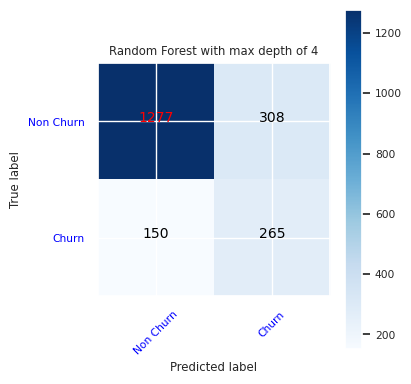

In [26]:
#Random Forest, max depth 4, 4 features
cfm = confusion_matrix(y_test, y_pred=ypred_rfc1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 4')
tn, fp, fn, tp = cfm.ravel()

The confusion matrix for the Random Forest classifier with a maximum depth of 4 reveals a moderately effective model for predicting customer churn. With 1277 true negatives and 265 true positives, the classifier correctly identifies a substantial portion of both churn and non-churn cases. However, the presence of 308 false positives and 150 false negatives indicates room for improvement, particularly in minimizing misclassifications that could lead to misguided retention strategies or missed churn signals. The relatively high false positive rate suggests the model may be overpredicting churn, which could result in unnecessary interventions.

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 35, Finished, Available, Finished)

[[1326  259]
 [ 155  260]]


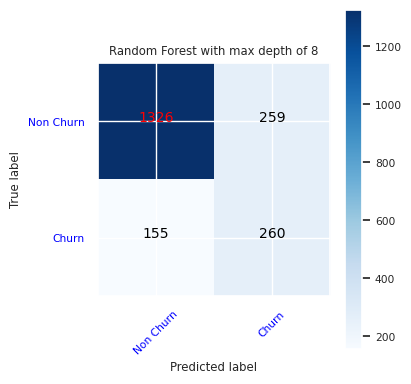

In [27]:
# Random Forest, max depth 8, 6 features
cfm = confusion_matrix(y_test, y_pred=ypred_rfc2_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 8')
tn, fp, fn, tp = cfm.ravel()

The confusion matrix for the Random Forest model with a maximum depth of 8 shows a slight improvement in overall classification performance compared to the depth-4 model. The number of true negatives increased from 1277 to 1326, and false positives decreased from 308 to 259, indicating better precision in identifying non-churn customers. However, the true positives dropped marginally from 265 to 260 and false negatives rose slightly from 150 to 155, suggesting a minor decline in recall for churn prediction. This trade-off reflects a model that has become more conservative in predicting churn, favoring fewer false alarms at the cost of missing a few actual churn cases. Overall, the depth-8 model demonstrates enhanced specificity and slightly better balance, but further tuning may be needed to optimize recall without sacrificing precision

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 36, Finished, Available, Finished)

[[1390  195]
 [ 171  244]]


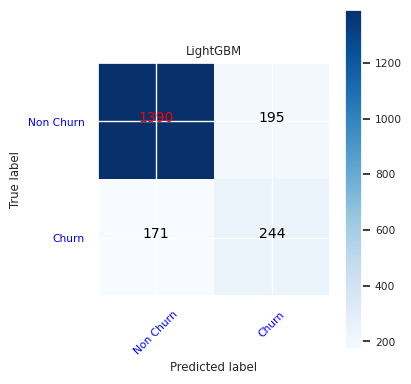

In [28]:
#Light GBM
cfm = confusion_matrix(y_test, y_pred=ypred_lgbm1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='LightGBM')
tn, fp, fn, tp = cfm.ravel()

The LightGBM model's confusion matrix shows a strong performance in identifying non-churn customers, with 1390 true negatives and only 195 false positives—both improvements over the Random Forest models. However, it struggles slightly more with churn prediction, yielding 244 true positives and 171 false negatives. Compared to the Random Forest with depth 8 (260 TP, 155 FN), LightGBM sacrifices some recall for churn in exchange for higher precision on non-churn. This trade-off may be acceptable depending on business priorities: if minimizing false alarms is more critical than catching every churn case, LightGBM offers a compelling balance.

Across all three models, LightGBM emerges as the most effective overall. It delivers the highest true negative count and the lowest false positive rate, indicating superior precision in identifying loyal customers. While its churn recall is slightly lower than the Random Forest with depth 8, the overall classification balance and reduced misclassification make it a stronger candidate for deployment—especially in scenarios where over-targeting non-churn customers could lead to wasted retention efforts. Further tuning could help recover some recall without compromising its precision advantage.


### C) Conclusion:

In conclusion, LightGBM shows the most effective result in prediction. These results will be saved in df_pred_result for further comparison with different tuning set.

In [29]:
df_pred = X_test.copy()
df_pred['y_test'] = y_test
df_pred['ypred_rfc1_sm'] = ypred_rfc1_sm
df_pred['ypred_rfc2_sm'] =ypred_rfc2_sm
df_pred['ypred_lgbm1_sm'] = ypred_lgbm1_sm
table_name = "df_pred_results"
sparkDF=spark.createDataFrame(df_pred)
sparkDF.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")
display(df_pred)

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 37, Finished, Available, Finished)

Spark dataframe saved to delta table: df_pred_results


SynapseWidget(Synapse.DataFrame, b069cee4-6887-40c2-ba2b-6137b467543e)

In [30]:
#Save df_pred as CSV to Lakehouse Files.
csv_path = "/lakehouse/default/Files/df_pred_results.csv"
df_pred.to_csv(csv_path, index=False)
print(f"CSV saved to: {csv_path}")

StatementMeta(, 5bed36a6-06b6-459d-8d3f-69da256758f2, 39, Finished, Available, Finished)

CSV saved to: /lakehouse/default/Files/df_pred_results.csv
